In [ ]:
from adaptive_mesh_refiner.adaptive_meshing import AdaptiveMeshRefiner
from src.radiation_algorithm.radiation_algorithm import radiation_algorithm
from efield.efield1 import calculate_electric_magnetic_field_at_point
from efield.efield2 import radiation_intensity_distribution_over_sphere_surface
from efield.efield3 import antenna_directivity_pattern

import numpy as np
import os
import time

# fonction utiles

In [ ]:
def traitement_de_(filename):
    base_name = os.path.splitext(os.path.basename(filename))[0]
    print(f"Traitement de l'antenne {base_name}")

filename_mesh1_IFA = 'data/antennas_mesh/IFA2.mat'

# Fonctions de generation de la geometrie

In [45]:
# Fonction pour générer les points de l'antenne IFA
def generate_ifa_antenna_points(L, H, ML, MH, gap, Lp):
    points = np.array([
        [0, 0], [L, 0], [L, H], [0, H], [0, H + MH], [L, H + MH], [L, H + gap], 
        [L - ML, H + gap], [L - ML, H + MH - ML], [2 * ML + Lp, H + MH - ML], 
        [2 * ML + Lp, H], [ML + Lp, H], [ML + Lp, H + MH - ML], [ML, H + MH - ML], [ML, H]
    ])
    return points

In [46]:
# Fonction pour générer les segments de l'antenne IFA   ([10, 11] feed edge)
def generate_ifa_antenna_segments():
    segments = np.array([
        [0, 1], [1, 2], [2, 10], [10, 9], [9, 8], [8, 7], [7, 6], [6, 5], [5, 4], [4, 3], 
        [0, 3], [11, 12], [12, 13], [13, 14], [11, 14], [10, 11]
    ])
    return segments

In [47]:
# Définition des dimensions de l'antenne IFA
L = 0.02
H = 0.05
ML = 0.001
MH = 0.015
gap = 0.0015
Lp = 0.0025

# Génération des points et des segments
vertices = generate_ifa_antenna_points(L, H, ML, MH, gap, Lp)
segments = generate_ifa_antenna_segments()
# Définition des trous (un point à l'intérieur de la zone à exclure)
holes = np.array([
    [(ML + ML + Lp) / 2, (H + (H + MH - ML)) / 2]
])

In [48]:
ifa_antenna = {
    'vertices': vertices,
    'segments': segments,
    'holes': holes
}


# Parametre pour la radiation

In [49]:
feed_point_IFA = [Lp + 3 * ML / 2, H, 0]
voltage_amplitude = 1  # Valeur de l'amplitude égale à 1 volt

# Maillage Adaptatif for radiation

In [50]:
ifa_name = "IFA2"
ifa_folder = "data/antennas_mesh/"

# Création de l'objet de raffinage
mesh_ifa = AdaptiveMeshRefiner()

# Étape 1 : Génération de la triangulation initiale avec un niveau moyen
mesh_ifa.initial_meshing(ifa_antenna, ifa_name, ifa_folder, refinement_level="high")

# show_mesh(points, triangles, feed_point_IFA)  # Change "black" si besoin
mesh_ifa.show_mesh(feed_point_IFA)

Utilisation des options de triangulation : pq20a0.00001
Nombre de points = 153
Nombre de triangles = 219
Matrice points shape = (3, 153)
Matrice triangles shape = (4, 219)
Data saved successfully to data/antennas_mesh/IFA2.mat


In [ ]:
number_of_refinement = 5  # Nombre maximum d'itérations

tolerance = 1e-2  # Seuil de variation relatif (1%)

previous_impedance = None  # Stocke l'impédance de l'itération précédente
actual_iterations = 0  # Compteur d'itérations effectives

for i in range(number_of_refinement):
    start_time = time.time()
    
    traitement_de_(filename_mesh1_IFA)
    impedance, selected_triangles = radiation_algorithm(filename_mesh1_IFA, 2.4e9, feed_point_IFA, voltage_amplitude, load_from_matlab=False)
    
    elapsed_time = time.time() - start_time
    print(f"Temps écoulé pour le traitement de l'antenne étudiée : {elapsed_time:.6f} secondes")
    print(f"Impédance actuelle : {impedance}\n")

    actual_iterations += 1
    
    # Vérifier la convergence de l'impédance
    if previous_impedance is not None:
        delta_impedance = np.abs(impedance - previous_impedance) / np.abs(previous_impedance)
        print(f"Variation relative de l'impédance : {delta_impedance:.6f}")

        if delta_impedance < tolerance:
            print("La variation de l'impédance est inférieure au seuil. Arrêt du raffinage.")
            break  # Sortir de la boucle

    previous_impedance = impedance  # Mettre à jour l'impédance précédente

    # Tentative d'affinage du maillage
    try:
        mesh_ifa.adaptative_meshing(ifa_antenna, selected_triangles, ifa_name, ifa_folder)
    except ValueError as e:
        print(f"Exception attrapée : {e}")
        break  # Arrêter si une erreur survient

# Affichage du nombre d'itérations utilisées
print(f"Nombre total d'itérations effectuées : {actual_iterations}")


Traitement de l'antenne IFA2
Total numbers of Edges is = 285
Aucune jonction complexe trouvée....
Total numbers of Edges is = 285
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 0.142396 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 46
La valeur de l'impédance d'entrée de l'antenne IFA2 =  118.5115005 + 173.6753568i Ohm
Gap current of IFA2 = (0.0026807640750917297-0.0039285862983903085j)
Gap voltage of IFA2 = (1+0j)
La valeur de feed_power  = 0.0013403820375458648
Data saved successfully to data/antennas_current/IFA2_current.mat
Sauvegarde du fichier : IFA2_current.mat effectué avec succès !
Fréquence de rayonnement de l'antenne : 2400000000.0 Hz
Max Current value = 10.1633431450

Temps écoulé pour le traitement de l'antenne étudiée : 1.067145 secondes
Impédance actuelle : (118.51150051590585+173.67535675907345j)

Après raffinage
Nombre de points = 371
Nombre de triangles = 655
Matrice points shape = (3, 371)
Matrice triangles shape = (4, 655)
Data saved successfully to data/antennas_mesh/IFA2.mat
Traitement de l'antenne IFA2
Total numbers of Edges is = 939
Aucune jonction complexe trouvée....
Total numbers of Edges is = 939
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 1.407952 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 372
La valeur de l'impédance d'entrée de l'antenne IFA2 =  118.0500025 + 172.9016057i Ohm
Gap current of IFA2 = (0.00269331355485268

Temps écoulé pour le traitement de l'antenne étudiée : 9.383414 secondes
Impédance actuelle : (118.05000246942895+172.90160568783116j)

Variation relative de l'impédance : 0.004285
La variation de l'impédance est inférieure au seuil. Arrêt du raffinage.
Nombre total d'itérations effectuées : 2


# Plot graph

In [52]:
filename_mesh2_IFA2 = 'data/antennas_mesh2/IFA2_mesh2.mat'
filename_current_IFA2 = 'data/antennas_current/IFA2_current.mat'
filename_gain_power_IFA2 = 'data/antennas_gain_power/IFA2_gain_power.mat'
filename_sphere_dense = 'data/sphere_mesh/sphere_dense.mat'

In [ ]:
# Point d'observation pour le calcul des champs
observation_point = np.array([0, 0, 10])

# Étape 1 : Calcul du champ électrique et magnétique à un point donné
print("Calculating electric and magnetic fields at observation point...")
calculate_electric_magnetic_field_at_point(filename_mesh2_IFA2, filename_current_IFA2, observation_point, radiation=True)

Calculating electric and magnetic fields at observation point...
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat

Frequency = 2400000000.0 Hz
Longueur d'onde lambda = 0.12489681415858718 m
Le point d'observation est : [ 0  0 10]

e_field_total of IFA2 at the observation point [ 0  0 10] is :
-0.0025730 - 0.0028595i V/m
-0.0295820 + 0.0194646i V/m
-0.0001075 + 0.0000268i V/m

h_field_total of IFA2 at the observation point [ 0  0 10] is :
 0.0000785 - 0.0000517i A/m
-0.0000068 - 0.0000076i A/m
-0.0000000 - 0.0000002i A/m

Poynting vector is equal to : 
-0.000000 W/m^2
-0.000000 W/m^2
 0.000002 W/m^2

w = 1.683669706449169e-06 W/m^2

u = 0.0001683669706449169 W/unit solid angle


In [54]:
# Étape 2 : Distribution de l'intensité du rayonnement sur une sphère
print("Calculating radiation intensity distribution over sphere surface...")
radiation_intensity_distribution_over_sphere_surface(filename_mesh2_IFA2, filename_current_IFA2, filename_sphere_dense, radiation=True)

Calculating radiation intensity distribution over sphere surface...
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat

Frequency = 2400000000.0 Hz
Longueur d'onde lambda = 0.12489681415858718 m

Total Power :  0.001398
Gain Linear :  2.166817
Gain Logarithmic :  3.358223 dB
Radiation Resistance :  122.578672 Ohms
Data saved successfully to data/antennas_gain_power/IFA2_gain_power.mat


Generating antenna directivity pattern...
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_gain_power/IFA2_gain_power.mat


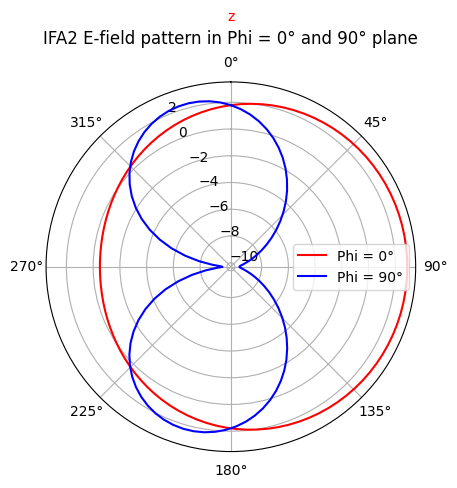

In [55]:
# Étape 3 : Génération du diagramme de directivité
print("Generating antenna directivity pattern...")
antenna_directivity_pattern(filename_mesh2_IFA2, filename_current_IFA2, filename_gain_power_IFA2, radiation=True)